This notebook will train a logistic PD model on our Lending Club dataset. 
We’ll cover:

1. Chronological train / OOT split
2. Class balancing (SMOTE-style oversampling)
3. Feature assembly & standardisation
4. Logistic regression
5. Evaluation: AUC & KS

At each step, there will be explanations of *why* that particular step is important for a robust, production-grade PD model.


## 0. Import Libraries

In [1]:
# Import function to start Spark
from init_spark import start_spark
spark = start_spark()

from pyspark.sql.functions import (
    col, when, count, desc, isnan, isnull, lit, length, trim, lower, upper, to_date, concat_ws,  regexp_extract, sum 
)



from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, IntegerType, DateType, NumericType
) 

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/14 23:50:32 WARN Utils: Your hostname, Chengs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.77 instead (on interface en0)
25/07/14 23:50:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/lunlun/.ivy2.5.2/cache
The jars for the packages stored in: /Users/lunlun/.ivy2.5.2/jars
io.delta#delta-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f53c8f44-c563-4b78-887b-3937d3c0deec;1.0
	confs: [default]
	found io.delta#delta-spark_2.13;4.0.0 in central
	found io.delta#delta-storage;4.0.0 in central
	found org.antlr#antlr4-runtime;4.13.1 in central
:: resolution report :: 

4.0.0


In [2]:
print(spark.sparkContext._jsc.sc().listJars())


List(spark://192.168.0.77:64348/jars/io.delta_delta-spark_2.13-4.0.0.jar, spark://192.168.0.77:64348/jars/org.antlr_antlr4-runtime-4.13.1.jar, spark://192.168.0.77:64348/jars/io.delta_delta-storage-4.0.0.jar)


In [3]:
print(spark.version)


4.0.0


In [4]:

# Check if Gold Delta is accessible for subsequent model building 
df = spark.read.format("delta")\
    .load("../data/gold/ready_for_pd_modeling")
    
df.limit(10).toPandas()

25/07/14 23:50:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,mo_sin_rcnt_tl,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit,loan_amnt_annual_inc_ratio,tl_op12m_inq6m,dti_inq,dti_bc_util,revol_util_fractional,fico_score,acc_open24m_revol_util,loan_amnt_bc_open_to_buy,dti_verified_multiply,issue_d,default_status
0,2.0,3.0,50.0,13600.0,0.339242,3.0,19.80,1506.780,0.0,677.0,321.5,2.080774,19.80,2016-07-01,0
1,19.0,0.0,25.0,38000.0,0.105700,0.0,0.00,1916.392,0.0,722.0,48.3,0.367625,33.68,2016-07-01,0
2,3.0,2.0,50.0,11900.0,0.207315,2.0,8.09,436.860,32.0,677.0,128.0,3.105023,0.00,2016-07-01,0
3,4.0,1.0,50.0,6500.0,0.416649,1.0,4.95,257.895,49.8,662.0,99.6,3.211304,4.95,2016-07-01,0
4,36.0,0.0,100.0,9500.0,0.211396,0.0,0.00,2600.794,0.0,742.0,0.0,11.014625,27.58,2016-07-01,0
5,5.0,1.0,25.0,15900.0,0.245391,0.0,0.00,321.555,0.0,672.0,121.8,0.976443,0.00,2016-07-01,0
6,8.0,2.0,50.0,10900.0,0.266663,0.0,0.00,1414.266,0.0,662.0,255.2,5.537099,21.14,2016-07-01,0
7,2.0,2.0,66.7,24400.0,0.049999,4.0,54.10,2161.295,73.3,722.0,293.2,0.509061,27.05,2016-07-01,0
8,15.0,0.0,50.0,5700.0,0.198657,0.0,0.00,2435.602,82.9,697.0,165.8,11.421971,29.38,2016-07-01,0
9,5.0,3.0,25.0,10300.0,0.181810,6.0,19.86,171.789,0.0,702.0,52.0,0.469428,0.00,2016-07-01,0


## 1. Chronological Training / Out-of-Time Split 
Out of Time Split refers to separating datasets into distinct time periods for model training and model testing stage. This is especially important, since it mitigates against data leakage. For example, if our training and testing splits are random, the model may 'peek' into future defaults while being trained, resulting in a model that is only good in training data, and not test data. On the contrary, if we use out-of-time splits, the model is only being trained on 2022 data, while being tested on 2023 data. This ensures that our model is only being trained on past predictions, to make a reasonably accurate forecast of credit risk on future loans. Our model can then steer itself away from being labeled as 'overfitted model', and be a model that truly generalises across data points to capture real patterns of borrowers / loans. 

In [5]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, col

# 1) Convert to numeric timestamp
df_ts = df.withColumn("issue_ts", unix_timestamp(col("issue_d")))

# 2) Compute the 80th percentile of that timestamp
quantiles = df_ts.stat.approxQuantile("issue_ts", [0.8], 0.01)
cut_ts = quantiles[0]  # e.g. 1672531200

# 3) Convert back to a human date
cut_date = (
    df_ts
    .select(from_unixtime(lit(cut_ts), "yyyy-MM-dd").alias("cut_date"))
    .first()["cut_date"]
)

print(f"Splitting at ≈ {cut_date}")

# 4) Train-test split
train_df = df.filter(col("issue_d") < cut_date) # train using 80% of the data before cut-off data at 80% 
test_df  = df.filter(col("issue_d") >= cut_date)


Splitting at ≈ 2018-01-01


In [6]:
train_df = df.filter(col("issue_d") < cut_date)

# Train and Test Datasets should have both default and non-defaulted class
train_df.groupBy("default_status").count().show()
test_df.groupBy("default_status").count().show()


+--------------+-------+
|default_status|  count|
+--------------+-------+
|             1| 228507|
|             0|1473347|
+--------------+-------+

+--------------+------+
|default_status| count|
+--------------+------+
|             1|  7511|
|             0|473823|
+--------------+------+



In [7]:
print("\n=== First / last 5 rows of train_df issue_d ===")
train_df.select("issue_d").orderBy(col("issue_d").asc()).show(5)
train_df.select("issue_d").orderBy(col("issue_d").desc()).show(5)


=== First / last 5 rows of train_df issue_d ===
+----------+
|   issue_d|
+----------+
|2007-06-01|
|2007-07-01|
|2007-07-01|
|2007-07-01|
|2007-07-01|
+----------+
only showing top 5 rows
+----------+
|   issue_d|
+----------+
|2017-12-01|
|2017-12-01|
|2017-12-01|
|2017-12-01|
|2017-12-01|
+----------+
only showing top 5 rows


In [8]:
print("\n=== First / last 5 rows of test_df issue_d ===")
test_df.select("issue_d").orderBy(col("issue_d").asc()).show(5)
test_df.select("issue_d").orderBy(col("issue_d").desc()).show(5)


=== First / last 5 rows of test_df issue_d ===
+----------+
|   issue_d|
+----------+
|2018-01-01|
|2018-01-01|
|2018-01-01|
|2018-01-01|
|2018-01-01|
+----------+
only showing top 5 rows
+----------+
|   issue_d|
+----------+
|2018-12-01|
|2018-12-01|
|2018-12-01|
|2018-12-01|
|2018-12-01|
+----------+
only showing top 5 rows


## 2. Feature Preparation


In [9]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# 1. Combine features into 1 single vector column named 'features_raw' 
numeric_cols = [f.name for f in df.schema.fields if f.name not in ('id', 'issue_d', 'default_status')]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_raw")
train_df_assembled = assembler.transform(train_df)

In [10]:
# 2. Scale Features (so Logistic Regression won't be affected by scale)
# scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
# scaler_model = scaler.fit(train_df_assembled)
# train_df_scaled = scaler_model.transform(train_df_assembled)
# train_df_scaled.limit(5).toPandas()

## 3. Class-Weighting Class Imbalance 

Credit datasets are inherently imbalanced, i.e default rates often make up ≤ 10% of observations. A normal classifier will often be biased towards the majority of non-default classes. Often, there will be seemingly highly predictive results, such as 99% accuracy. However, it is important to note that Accuracy can be deceptive. For example, since accuracy is defined by correct predictions / all predictions, 
if only 5% of borrowers default, a classifier which always predicts 'non-default' will be correct 95% of the time. This model is hence unhelpful in identifying defaulters. 

To deal with class imbalance, we do have a few options, i.e. SMOTE (oversampling) and class-weighting. However, the creation of new feature vectors in SMOTE is computationally expensive and my local machine couldn't handle SMOTE and the loading of the 4 million rows dataset. Though there are big data libraries to conduct SMOTE out there like ASMOTE, such libraries support only Pyspark 3.x.x, which is uncompatible with our `delta-lake`. Class weighting solves this by making the model pay more attention to the rare class (defaults) without generating fake data.

Specifically, every training observation is given a weight. These weights will tell the model how important each row is. Ultimately, each default can then contribute as much influence as a non-default. 

In [11]:
# Step 4: Compute class weights and assign to column
count_pos = train_df_assembled.filter("default_status == 1").count()
count_neg = train_df_assembled.filter("default_status == 0").count()
balancing_ratio = count_neg / count_pos # non-default is > default 
train_df_assembled.limit(10).toPandas()

,mo_sin_rcnt_tl,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit,loan_amnt_annual_inc_ratio,tl_op12m_inq6m,dti_inq,dti_bc_util,revol_util_fractional,fico_score,acc_open24m_revol_util,loan_amnt_bc_open_to_buy,dti_verified_multiply,issue_d,default_status,features_raw
0,6.0,2.0,37.5,16300.0,0.340894,0.0,0.00,857.4,51.5,662.0,206.0,1.380707,0.0,2007-06-01,0,"[6.0, 2.0, 37.5, 16300.0, 0.3408935957456479, ..."
1,6.0,2.0,37.5,16300.0,0.025000,0.0,0.00,223.2,0.7,812.0,2.8,0.920471,0.0,2007-07-01,0,"[6.0, 2.0, 37.5, 16300.0, 0.024999875000624998..."
2,6.0,2.0,37.5,16300.0,0.071621,0.0,0.00,862.2,14.4,797.0,57.6,0.975700,0.0,2007-07-01,0,"[6.0, 2.0, 37.5, 16300.0, 0.07162065377494899,..."
3,6.0,2.0,37.5,16300.0,0.166661,0.0,0.00,1118.4,47.1,702.0,188.4,0.920471,0.0,2007-07-01,0,"[6.0, 2.0, 37.5, 16300.0, 0.16666111129629013,..."
4,6.0,2.0,37.5,16300.0,0.204163,4.0,34.24,1027.2,8.1,747.0,32.4,2.255155,0.0,2007-07-01,0,"[6.0, 2.0, 37.5, 16300.0, 0.20416326394560091,..."
5,6.0,2.0,37.5,16300.0,0.050000,0.0,0.00,138.0,19.4,742.0,77.6,0.920471,0.0,2007-07-01,0,"[6.0, 2.0, 37.5, 16300.0, 0.04999950000499995,..."
6,6.0,2.0,37.5,16300.0,0.022727,0.0,0.00,679.8,13.1,762.0,52.4,0.460236,0.0,2007-07-01,0,"[6.0, 2.0, 37.5, 16300.0, 0.022727066117580748..."
7,6.0,2.0,37.5,16300.0,0.159370,0.0,0.00,886.8,23.9,772.0,95.6,0.938881,0.0,2007-07-01,0,"[6.0, 2.0, 37.5, 16300.0, 0.15937001968688477,..."
8,6.0,2.0,37.5,16300.0,0.015000,0.0,0.00,0.0,0.0,677.0,0.0,0.552283,0.0,2007-07-01,0,"(6.0, 2.0, 37.5, 16300.0, 0.014999925000374998..."
9,6.0,2.0,37.5,16300.0,0.058823,0.0,0.00,18.6,0.6,787.0,2.4,0.920471,0.0,2007-07-01,0,"[6.0, 2.0, 37.5, 16300.0, 0.058822837378383785..."


In [12]:
from pyspark.sql import functions as F

# Select vector column, target column, and newly created class_weight 
train_df_weighted = train_df_assembled.withColumn(
    "class_weight",
    F.when(F.col("default_status") == 1, balancing_ratio).otherwise(1.0)
).select("features_raw", "default_status", "class_weight")
train_df_assembled

DataFrame[mo_sin_rcnt_tl: double, num_tl_op_past_12m: double, percent_bc_gt_75: double, total_bc_limit: double, loan_amnt_annual_inc_ratio: double, tl_op12m_inq6m: double, dti_inq: double, dti_bc_util: double, revol_util_fractional: double, fico_score: double, acc_open24m_revol_util: double, loan_amnt_bc_open_to_buy: double, dti_verified_multiply: double, issue_d: date, default_status: int, features_raw: vector]

## 4. Model Training 

In [14]:
from pyspark.ml.classification import LogisticRegression

# Step 5: Train logistic regression with class weights
lr = LogisticRegression(
    featuresCol="features_raw",
    labelCol="default_status",
    weightCol="class_weight"
)
model = lr.fit(train_df_weighted)

25/07/14 23:50:51 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


## 5. Model Training and Evaluation 

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Step 6: Prepare OOT data (assemble + scale using same transformers)
oot_df_assembled = assembler.transform(test_df)

# Step 7: Predict and evaluate on OOT
predictions = model.transform(oot_df_assembled)

evaluator = BinaryClassificationEvaluator(labelCol="default_status", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

auc

0.6349547568479386

In [ ]:
predictions.limit(10).toPandas()

,features,default_status,rawPrediction,probability,prediction
0,"[-0.34845224712383743, -0.6088527893473811, -0...",0,"[0.10449811105851267, -0.10449811105851267]","[0.52610078069069, 0.47389921930931]",0.0
1,"[2.1240275380763105, -1.1728303000560745, -1.2...",0,"[1.7518724917236705, -1.7518724917236705]","[0.8521888222854589, 0.1478111777145411]",0.0
2,"[-0.34845224712383743, -0.6088527893473811, -1...",0,"[0.7456648194755576, -0.7456648194755576]","[0.6782333522035525, 0.3217666477964475]",0.0
3,"[-0.5732231366874873, -0.04487527863868763, -0...",0,"[0.47571684961933325, -0.47571684961933325]","[0.6167359623854878, 0.3832640376145122]",0.0
4,"[0.10108953200346221, -0.6088527893473811, 0.6...",0,"[0.015226858509854557, -0.015226858509854557]","[0.5038066410779797, 0.4961933589220203]",0.0
5,"[-0.12368135756018761, -0.04487527863868763, -...",0,"[1.5711814466923846, -1.5711814466923846]","[0.8279519676145862, 0.17204803238541377]",0.0
6,"[-0.5732231366874873, -0.04487527863868763, -1...",0,"[1.1252389391223334, -1.1252389391223334]","[0.7549591922969403, 0.2450408077030597]",0.0
7,"[-0.23606680234201252, -0.6088527893473811, 0....",0,"[-0.16133182800972165, 0.16133182800972165]","[0.45975429794281625, 0.5402457020571838]",1.0
8,"[-0.7979940262511371, -0.04487527863868763, -0...",0,"[1.297197865782402, -1.297197865782402]","[0.7853630107258669, 0.2146369892741331]",0.0
9,"[-0.34845224712383743, -0.6088527893473811, 0....",0,"[0.5273372250679466, -0.5273372250679466]","[0.6288618481544875, 0.37113815184551247]",0.0


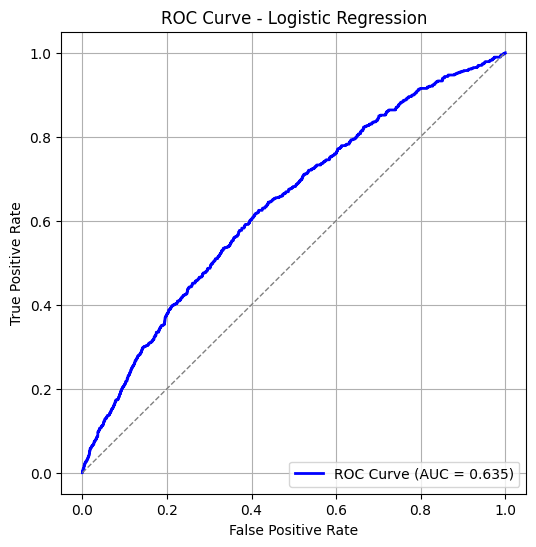

25/07/14 23:31:10 ERROR RetryingBlockTransferor: Exception while beginning fetch of 1 outstanding blocks (after 2 retries)
java.io.IOException: Connecting to /10.106.14.41:60819 failed in the last 4750 ms, fail this connection directly
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:221)
	at org.apache.spark.network.netty.NettyBlockTransferService$$anon$2.createAndStart(NettyBlockTransferService.scala:137)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.transferAllOutstanding(RetryingBlockTransferor.java:181)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.lambda$initiateRetry$0(RetryingBlockTransferor.java:228)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30)
	at java.base/java.lang.

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Assume you've already trained your model and transformed predictions
# predictions = model.transform(test_data)

# Extract true default_status and probability of class 1
sampled_preds = predictions.select("default_status", "probability").sample(fraction=0.1, seed=42)  # Try 0.01 or 0.05 if still slow

# Convert to Pandas for plotting
preds_pd = sampled_preds.rdd.map(lambda row: (float(row['default_status']), float(row['probability'][1]))).toDF(["default_status", "prob_1"]).toPandas()

from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(preds_pd['default_status'], preds_pd['prob_1'])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
# Youden's J statistic
j_scores = tpr - fpr
j_best_idx = j_scores.argmax()
optimal_threshold = thresholds[j_best_idx]

print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")


Optimal Threshold (Youden's J): 0.4545


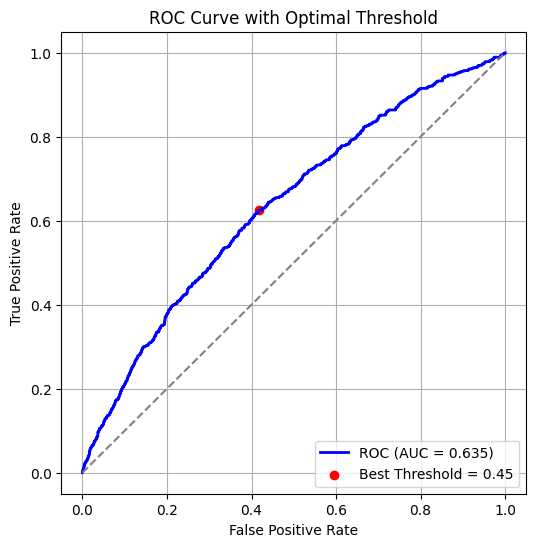

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.scatter(fpr[j_best_idx], tpr[j_best_idx], color='red', label=f'Best Threshold = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Threshold')
plt.legend(loc='lower right')
plt.grid()
plt.show()
